In [ ]:
!git clone https://github.com/bat67/TibetanMNIST.git

Cloning into 'TibetanMNIST'...
remote: Enumerating objects: 17796, done.
remote: Total 17796 (delta 0), reused 0 (delta 0), pack-reused 17796 (from 1)
Receiving objects: 100% (17796/17796), 111.58 MiB | 18.56 MiB/s, done.
Resolving deltas: 100% (38/38), done.
Updating files: 100% (17789/17789), done.


In [ ]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 48.7 MB/s eta 0:00:00


In [ ]:
import os
from dataclasses import dataclass
from typing import Tuple
import numpy as np
import pandas as pd
import torch
from IPython.display import display
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
#using tensor metrics instead of numpy arrays
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassCohenKappa, MulticlassAUROC, MulticlassConfusionMatrix
from torchvision import transforms
from torch import optim, nn, utils, Tensor
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import lightning as L
from lightning.pytorch.loggers import CSVLogger

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_path):
        # Load the data
        data = np.load(data_path)
        print(f"Available keys in the .npz file: {data.files}")

        # Define class objects
        self.images = data['image']
        self.labels = data['label']

        # Debugging: Check shapes and values
        print(f"Shape of images: {self.images.shape}")
        print(f"Shape of labels: {self.labels.shape}")
        print(f"Unique labels: {np.unique(self.labels)}")  # Check unique values in labels

    def __len__(self):
        # Define number of samples
        return len(self.labels)

    def __getitem__(self, idx):
        # Define feature and target
        x_temp = self.images[idx]
        y_temp = self.labels[idx]

        # Convert to torch tensors
        x = torch.tensor(x_temp, dtype=torch.float32).unsqueeze(0)
        y = torch.tensor(y_temp, dtype=torch.int64)

        return x, y

In [ ]:
# Load Dataset
dataset = CustomDataset('TibetanMNIST/Datasets/TibetanMNIST.npz')

Available keys in the .npz file: ['image', 'label']
Shape of images: (17768, 28, 28)
Shape of labels: (17768,)
Unique labels: [0 1 2 3 4 5 6 7 8 9]


In [ ]:
# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))    # 15% for validation
test_size = len(dataset) - train_size - val_size  # Remaining 15% for testing

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
#Simple model
class SimpleTibetanNumberClassifier(L.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.num_classes = num_classes
        self.l1 = torch.nn.Linear(28 * 28, num_classes)

        # Defining the tensor metrics from the torch library
        self.val_accuracy = MulticlassAccuracy(num_classes=self.num_classes)
        self.val_precision_metrics = MulticlassPrecision(num_classes=self.num_classes)
        self.val_recall_metrics = MulticlassRecall(num_classes=self.num_classes)
        self.val_auroc_metrics = MulticlassAUROC(num_classes=self.num_classes)
        self.val_confusion_matrix = MulticlassConfusionMatrix(num_classes=self.num_classes, normalize=None)
        self.val_f1_metrics = MulticlassF1Score(num_classes=self.num_classes)
        self.val_cohen_kappa_metrics = MulticlassCohenKappa(num_classes=self.num_classes)

        # Test metrics
        self.test_accuracy = MulticlassAccuracy(num_classes=self.num_classes)
        self.test_precision_metrics = MulticlassPrecision(num_classes=self.num_classes)
        self.test_recall_metrics = MulticlassRecall(num_classes=self.num_classes)
        self.test_auroc_metrics = MulticlassAUROC(num_classes=self.num_classes)
        self.test_confusion_matrix = MulticlassConfusionMatrix(num_classes=self.num_classes, normalize=None)
        self.test_f1_metrics = MulticlassF1Score(num_classes=self.num_classes)
        self.test_cohen_kappa_metrics = MulticlassCohenKappa(num_classes=self.num_classes)


    def forward(self, x):
        return self.l1(x.view(x.size(0), -1))

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)  # Use cross_entropy for classification
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        #preds = torch.argmax(logits, dim=1)
        preds = torch.softmax(logits, dim=1)
        # Update metrics inside `on_validation_batch_end`
        self.val_accuracy.update(preds, y)
        self.val_precision_metrics.update(preds, y)
        self.val_recall_metrics.update(preds, y)
        self.val_auroc_metrics.update(preds, y)
        self.val_confusion_matrix.update(preds, y)
        self.val_f1_metrics.update(preds, y)
        self.val_cohen_kappa_metrics.update(preds, y)

        # logging
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)
        self.log("val_precision", self.val_precision_metrics, prog_bar=True)
        self.log("val_recall", self.val_recall_metrics, prog_bar=True)
        self.log("val_auroc", self.val_auroc_metrics, prog_bar=True)
        # Lightning's progress bar expects single scalar values for logging which is not applicable for confusion matrices
        #leave the logging for confusion matrices completely out! only plot the confusion matrix after each loop completed
        #self.log("val_confusion_matrix", self.val_confusion_matrix, prog_bar=False, on_epoch=False, on_step=True)
        self.log("val_f1", self.val_f1_metrics, prog_bar=True)
        self.log("val_cohen_kappa", self.val_cohen_kappa_metrics, prog_bar=True)


    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.softmax(logits, dim=1)

        # Update test metrics
        self.test_accuracy.update(preds, y)
        self.test_precision_metrics.update(preds, y)
        self.test_recall_metrics.update(preds, y)
        self.test_auroc_metrics.update(preds, y)
        self.test_confusion_matrix.update(preds, y)
        self.test_f1_metrics.update(preds, y)
        self.test_cohen_kappa_metrics.update(preds, y)

        # Log test metrics
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
        self.log("test_precision", self.test_precision_metrics, prog_bar=True)
        self.log("test_recall", self.test_recall_metrics, prog_bar=True)
        self.log("test_auroc", self.test_auroc_metrics, prog_bar=True)
        #self.log("test_confusion_matrix", self.test_confusion_matrix, prog_bar=False, on_epoch=True, on_step=False)
        self.log("test_f1", self.test_f1_metrics, prog_bar=True)
        self.log("test_cohen_kappa", self.test_cohen_kappa_metrics, prog_bar=True)

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [ ]:
# Initialize the model
model = SimpleTibetanNumberClassifier()

In [ ]:
# train with both splits (simple model)
trainer = L.Trainer(max_epochs=10, logger=CSVLogger(save_dir="csv_logs", name="TibetanMNIST"))
trainer.fit(model, train_loader, val_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
   | Name                     | Type                      | Params | Mode 
--------------------------------------------------------------------------------
0  | l1                       | Linear                    | 7.9 K  | train
1  | val_accuracy             | MulticlassAccuracy        | 0      | train
2  | val_precision_metrics    | MulticlassPrecision       | 0      | train
3  | val_recall_metrics       | MulticlassRecall          | 0      | train
4  | val_auroc_metrics        | MulticlassAUROC           | 0      | train
5  | val_confusion_matrix     | MulticlassConfusionMatrix | 0      | train
6  | val_f1_metric

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
# After training, run the test step to get predictions and true labels
trainer.test(model=model, dataloaders=test_loader)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.887057900428772     │
│        test_auroc         │    0.9773691892623901     │
│     test_cohen_kappa      │    0.8747768402099609     │
│          test_f1          │    0.8829886317253113     │
│         test_loss         │     10.9918794631958      │
│      test_precision       │    0.8866392374038696     │
│        test_recall        │     0.887057900428772     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 10.9918794631958,
  'test_acc': 0.887057900428772,
  'test_precision': 0.8866392374038696,
  'test_recall': 0.887057900428772,
  'test_auroc': 0.9773691892623901,
  'test_f1': 0.8829886317253113,
  'test_cohen_kappa': 0.8747768402099609}]

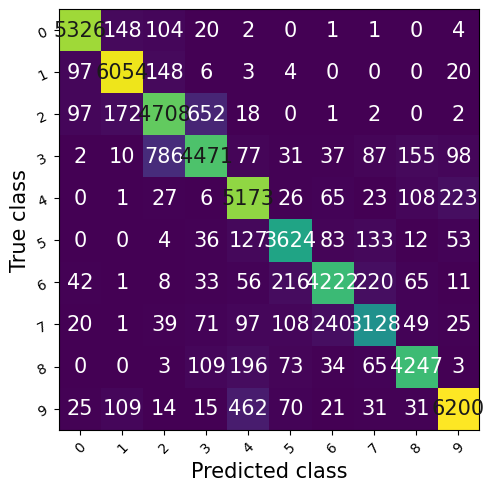

In [ ]:
#plot the confusion matrix for validation
model.val_confusion_matrix.plot()
plt.show()

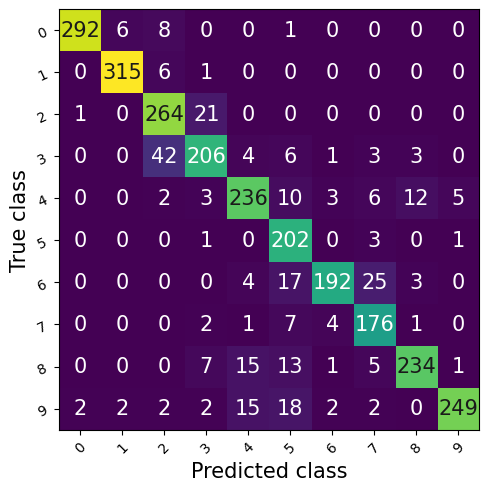

In [ ]:
#plot the confusion matrix for test
model.test_confusion_matrix.plot()
plt.show()